## 0. Imports

In [1]:
%matplotlib inline
from time import time
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go
import pickle

import nltk
nltk.download('stopwords') ## à executer qu'une fois
nltk.download('wordnet') ## à executer qu'une fois
nltk.download('punkt') ## à executer qu'une fois
nltk.download('average_perceptron_tagger') ## à executer qu'une fois

from nltk.tokenize import word_tokenize

import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag


stopwords = sw.words('english')

## sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
### models ML
from sklearn.svm import SVC, LinearSVC     # Support Vector Machine
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, ComplementNB, BernoulliNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import FastICA, KernelPCA, TruncatedSVD, SparsePCA, NMF, FactorAnalysis, LatentDirichletAllocation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anthony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/anthony/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/anthony/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading average_perceptron_tagger: Package
[nltk_data]     'average_perceptron_tagger' not found in index


## 1. Connection to mongodb

In [2]:
from pymongo import MongoClient
client = MongoClient("localhost", 27017)
db = client["StarkBotBD"]
db.Quest_Rep.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)], 'ns': 'StarkBotBD.Quest_Rep'},
 'text_search': {'v': 2,
  'key': [('_fts', 'text'), ('_ftsx', 1)],
  'ns': 'StarkBotBD.Quest_Rep',
  'weights': SON([('Body', 1), ('Title', 2)]),
  'default_language': 'english',
  'language_override': 'language',
  'textIndexVersion': 3},
 'Topic_1': {'v': 2, 'key': [('Topic', 1)], 'ns': 'StarkBotBD.Quest_Rep'},
 'Score_1': {'v': 2, 'key': [('Score', 1)], 'ns': 'StarkBotBD.Quest_Rep'},
 'PostTypeId_1': {'v': 2,
  'key': [('PostTypeId', 1)],
  'ns': 'StarkBotBD.Quest_Rep'},
 'ParentId_1': {'v': 2,
  'key': [('ParentId', 1)],
  'ns': 'StarkBotBD.Quest_Rep'},
 'AnswerCount_1': {'v': 2,
  'key': [('AnswerCount', 1)],
  'ns': 'StarkBotBD.Quest_Rep'},
 'Id_1': {'v': 2, 'key': [('Id', 1)], 'ns': 'StarkBotBD.Quest_Rep'}}

In [8]:
topics= db.Quest_Rep.distinct('Topic')
topics

['astronomy',
 'earthscience',
 'electronics',
 'engineering',
 'general',
 'space',
 'stellar']

In [9]:
nb_topics = len(topics)
nb_topics

7

In [11]:
list(range(nb_topics))

[0, 1, 2, 3, 4, 5, 6]

In [3]:
## Liste des Topic dans la BDD
topics = ['astronomy', 'earthscience', 'electronics', 'engineering', 'space', 'stellar', 'general']
le = LabelEncoder()
le.fit(topics)

LabelEncoder()

## 2. Corpus and Targets generation
Query mongodb BDD to create a liste of questions (corpus). 

Select n questions of each topics (nq_by_topic), if exist. <br>Else, select all available question in the topic.

In [4]:
nq_by_topic = 5000
corpus = []
target = []
for topic in topics:
    if db.Quest_Rep.find({"Topic": topic, "PostTypeId":"1"}).count()>=nq_by_topic:
        elmts_cursor = db.Quest_Rep.find({"Topic": topic, "PostTypeId":"1"}) \
                                        .sort([('Score', -1)]).limit(nq_by_topic)
        corpus.extend([elmt.get("Title") for elmt in elmts_cursor])
        target.extend([topic]*nq_by_topic)
    else:
        length = db.Quest_Rep.find({"Topic": topic, "PostTypeId":"1"}).count()
        elmts_cursor = db.Quest_Rep.find({"Topic": topic, "PostTypeId":"1"}) \
                                        .sort([('Score', -1)]).limit(length)
        corpus.extend([elmt.get("Title") for elmt in elmts_cursor])
        target.extend([topic]*length)
        

<ipython-input-4-582bde8629e8>:5: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if db.Quest_Rep.find({"Topic": topic, "PostTypeId":"1"}).count()>=nq_by_topic:
<ipython-input-4-582bde8629e8>:11: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  length = db.Quest_Rep.find({"Topic": topic, "PostTypeId":"1"}).count()


In [5]:
corpus = np.array(corpus)
target = np.array(target)

In [6]:
print(5000*5+1281+2726)

29007


In [7]:
target[29000:]

array(['general', 'general', 'general', 'general', 'general', 'general',
       'general'], dtype='<U12')

In [8]:
corpus[29000:]

array(["D'apres quel astronaute americain, le telescope spatial Hubble, lance en 1990 et place sur orbite basse, est-il nomme?",
       'Quel est le nom de la galaxie la plus proche de la Voie Lactée?',
       'Quel est le nom de la galaxie la plus proche de la Voie Lactee?',
       "God Save the Queen est l'hymne national de quel pays?",
       "De quel pays, God Save the Queen est l'hymne national?",
       'Le Plateau Celte, le fond marin sous la mer Celtique est une partie du plateau continental de quel continent?',
       'Les dauphins utilisent un sens, proche du sonar, pour déterminer la position et la forme des objets environnant.'],
      dtype='<U182')

In [9]:
## Taille des differents topics
for topic in topics:
    somme = db.Quest_Rep.find({"Topic": topic, "PostTypeId":"1"}).count()
    print(somme)

<ipython-input-9-88ca0a2af9ff>:3: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  somme = db.Quest_Rep.find({"Topic": topic, "PostTypeId":"1"}).count()


9995
5393
148171
10324
14295
1281
2726


In [10]:
## encode targets (str) to numerical (int)
y = le.transform(target)

In [11]:
vect = CountVectorizer(stop_words=stopwords)
X = vect.fit_transform(corpus)

In [12]:
X.shape

(29007, 18578)

## 3. Test first models

In [12]:
def run_pipes(pipes, splits, corpus, targets, test_size=0.2, seed=42):  
    res = defaultdict(list)
    spliter = ShuffleSplit(n_splits=splits, test_size=test_size, random_state=seed)
    for idx_train, idx_test in spliter.split(corpus, targets):
        for pipe in pipes:
            # name of the model
            name = "-".join([x[0] for x in pipe.steps])
            
            # extract datasets
            X_train = corpus[idx_train]
            X_test = corpus[idx_test]
            y_train = targets[idx_train]
            y_test = targets[idx_test]
            
            # Learn
            start = time()
            pipe.fit(X_train, y_train)
            fit_time = time() - start
            
            # predict and save results
            y = pipe.predict(X_test)
            res[name].append([
                fit_time,
                f1_score(y_test, y, average='micro'),
                f1_score(y_test, y, average='macro'),
                f1_score(y_test, y, average='weighted'),           
            ])
    return res


In [13]:
def print_table(res):
    # Compute mean and std
    final = {}
    for model in res:
        arr = np.array(res[model])
        final[model] = {
            "time (s)" : arr[:, 0].mean(),#.round(2),
            "f1_av_micro": [arr[:,1].mean().round(3), arr[:,1].std().round(3)],
            "f1_av_macro": [arr[:,2].mean().round(3), arr[:,2].std().round(3)],
            "f1_av_weighted": [arr[:,3].mean().round(3), arr[:,3].std().round(3)],
        }

    df = pd.DataFrame.from_dict(final, orient="index").round(3)
    return df

In [14]:
from sklearn.metrics import f1_score
pipe0 = Pipeline([
    ("ngram_stop", CountVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=2)),
    ('tfidf', TfidfTransformer()),
    ('sgd-weight_bal', SGDClassifier(max_iter = 2000, class_weight = 'balanced', penalty= 'elasticnet', loss = 'modified_huber')), #penalty{‘l2’, ‘l1’, ‘elasticnet’}
])                          # loss  ‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’, or a regression loss: ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’.
pipe1 = Pipeline([
    ("ngram_stop", CountVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=2)),
    ('tfidf', TfidfTransformer()),
    ('lin_svm-weight_bal', LinearSVC(class_weight = 'balanced', penalty='l1', loss = 'squared_hinge', dual=False)), # penalty{‘l1’, ‘l2’}: default : 'l2', loss{‘hinge’, ‘squared_hinge’} : default: 'square_hinge'
])                                                                                                                  # must : , penalty='l1', loss = 'squared_hinge', dual=False
pipe2 = Pipeline([
    ("ngram_stop", CountVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=2)),
    ('tfidf', TfidfTransformer()),
    ('lgr-weight_bal', LogisticRegression(max_iter = 2000, penalty = 'l1', solver='liblinear', class_weight = 'balanced')), # penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, dualbool, default=False
])                                                                                      # solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
pipe3 = Pipeline([
    ("ngram_stop", CountVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=2)),
    ('tfidf', TfidfTransformer()),
    ('dtc-weight_bal', DecisionTreeClassifier(class_weight = 'balanced')),
])
pipe4 = Pipeline([
    ("ngram_stop", CountVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=2)),
    ('tfidf', TfidfTransformer()),
    ('compl_nb-weight_bal', ComplementNB()),
])


res = run_pipes([pipe0, pipe1, pipe2, pipe3, pipe4], splits = 10, corpus=corpus, targets=y)
print_table(res)


/home/anthony/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/anthony/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


,time (s),f1_av_micro,f1_av_macro,f1_av_weighted
ngram_stop-tfidf-sgd-weight_bal,1.095,"[0.835, 0.006]","[0.849, 0.006]","[0.835, 0.006]"
ngram_stop-tfidf-lin_svm-weight_bal,2.076,"[0.828, 0.005]","[0.842, 0.005]","[0.827, 0.005]"
ngram_stop-tfidf-lgr-weight_bal,1.127,"[0.792, 0.006]","[0.809, 0.007]","[0.794, 0.006]"
ngram_stop-tfidf-dtc-weight_bal,8.400,"[0.694, 0.007]","[0.71, 0.007]","[0.691, 0.007]"
ngram_stop-tfidf-compl_nb-weight_bal,0.657,"[0.828, 0.005]","[0.841, 0.005]","[0.828, 0.005]"


In [ ]:
## sauvegarde
import pickle
filename = "classifier_topic.pickle"
pickle.dump(pipe0, open(filename, 'wb'))

In [25]:
filename = "classifier_topic.pickle"
model = pickle.load(open(filename, 'rb'))

In [16]:
y_pred=model.predict(corpus)
score = model.score(corpus, y)

In [23]:
pred = model.predict(["What is your name ?"])
print(le.inverse_transform(pred))

['earthscience']


In [36]:
liste_topic = list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6]))
liste_topic

['astronomy',
 'earthscience',
 'electronics',
 'engineering',
 'general',
 'space',
 'stellar']

In [69]:
pred_proba = model.predict_proba(["usb C"])

liste_proba = list(pred_proba[0])
liste_proba

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

In [70]:
liste_topic = list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6]))
pred_proba = model.predict_proba(["usb C"])
liste_proba = list(pred_proba[0])
rg = len(liste_proba)
for i in range(7):
    print(f'topic {i+1} :',liste_topic[np.argmax(liste_proba)])
    idx = np.argmax(liste_proba)
    print(idx)
    liste_proba.pop(idx)
    liste_topic.pop(idx)
    

topic 1 : electronics
2
topic 2 : astronomy
0
topic 3 : earthscience
0
topic 4 : engineering
0
topic 5 : general
0
topic 6 : space
0
topic 7 : stellar
0


In [33]:
dict_proba = {liste_topic[i]: liste_proba[i] for i in range(len(liste_proba))}

0.2999326189020622

['astronomy' 'earthscience' 'electronics' 'engineering' 'general' 'space'
 'stellar']


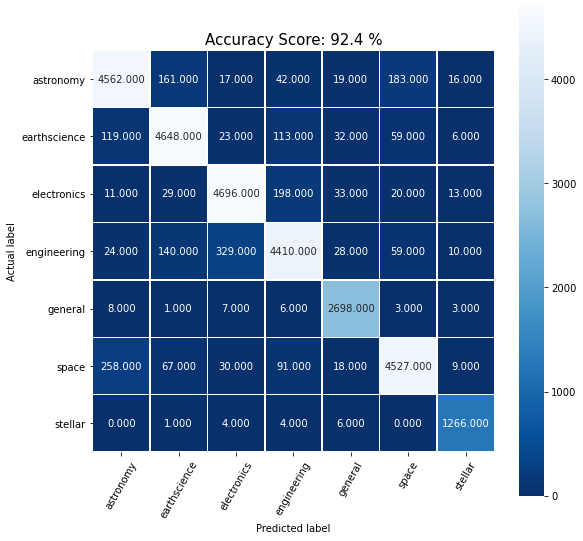

In [18]:
from sklearn import metrics
cm = metrics.confusion_matrix(y, y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.yticks(np.arange(len(topics))+0.5, tuple(le.inverse_transform([0, 1, 2, 3, 4, 5, 6])), rotation=0)
plt.ylabel('Actual label');
plt.xticks(np.arange(len(topics))+0.5, tuple(le.inverse_transform([0, 1, 2, 3, 4, 5, 6])), rotation=60)
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0} %'.format(round(score,3)*100)
plt.title(all_sample_title, size = 15);
print(le.inverse_transform([0, 1, 2, 3, 4, 5, 6]))

## Recherche d'optimum avec Grid search

In [19]:
from pipelinehelper import PipelineHelper
#
#pipe5 = Pipeline([
#    ('rbg2grey', RGB2GrayTransformer()),
#    ('hog', HogTransformer(pixels_per_cell=(14, 14), cells_per_block=(2, 2), 
#                           orientations=9, block_norm='L2-Hys')
#    ),
#    ('scaler', PipelineHelper([
#        ('std', StandardScaler()),
#        ('max', MaxAbsScaler()),
#    ])),
#    ('classifier', PipelineHelper([
#        ('sgd', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)),
#        ('svm', SVC()),
#        ('gnb', GaussianNB()),
#        ('cnb', ComplementNB()),
#    ])),
#])

pipe5 = Pipeline([
    ("vect", CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sgd', SGDClassifier()),
     ])

In [20]:
#params = {
#    'hog__orientations': [8, 9],
#    'hog__cells_per_block': [(2, 2), (3, 3), (4, 4)],
#    'hog__pixels_per_cell': [(8, 8), (10, 10), (12, 12)],
#    'scaler__selected_model': pipe.named_steps['scaler'].generate({
#        'std__with_mean': [True, False],
#        'std__with_std': [True, False],
#        'max__copy': [True],
#    }),
#    'classifier__selected_model': pipe.named_steps['classifier'].generate({
#        'sgd__loss': ['hinge', 'log', 'modified_huber', 'perceptron', 'squared_loss', 'huber'],
#        'svm__C': [0.1, 1.0],
#        'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
#    })
#}

params ={
    'vect__stop_words': [None, 'english'], ## stopvords
    'vect__ngram_range': [(1,2), (1,3)], ## ngrams
    'vect__min_df': [2],
    #'tfidf_use_idf': [True, False],
    'sgd__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0], ## learning rate
    'sgd__max_iter':[1000], ## nb of epochs
    'sgd__average': ['micro', 'macro', 'weighted'],
    'sgd__class_weight': ['micro', 'macro', 'balanced'], ## macro
    'sgd__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 
                  'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], ## model choice SVM, logistic reg...
    'sgd__penalty':['l2', 'l1', 'elasticnet']
}

## affichage des paramètre 

SGDClassifier().get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [27]:
params ={
    'vect__stop_words': ['english'], ## stopvords
    'vect__ngram_range': [(1,2)], ## ngrams
    'vect__min_df': [2],
    #'tfidf_use_idf': [True, False],
    'sgd__alpha': [ 1e-4, 1e-3], ## learning rate
    'sgd__max_iter':[1000], ## nb of epochs
    'sgd__average': ['micro', 'macro', 'weighted'],
    'sgd__class_weight': ['micro', 'macro', 'balanced'], ## macro
    'sgd__loss': ['hinge', 'modified_huber','squared_epsilon_insensitive'], ## model choice SVM, logistic reg...
    'sgd__penalty':['elasticnet']
}


from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
#f1_scorer = make_scorer(f1_score , average='macro')# Ne marche pas, utiliser onevsrestClassif ou onevsone
gs = GridSearchCV(pipe5, 
                  params, 
                  cv=3,
                  n_jobs=-1,
                  scoring='accuracy',
                  verbose=1,
                  return_train_score=True)
 
gs_res = gs.fit(corpus, y)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   53.5s finished


TypeError: '>' not supported between instances of 'str' and 'int'

In [ ]:
print('meilleur score obtenu :', gs_res.best_score_)
print('meilleur estimateur :', gs_res.best_estimator_)
print('meilleur paramètres :', gs_res.best_params_)